# Dogs vs. cats (Keras)

In this activity, the goal is to distinguish the animals pictured in these images between cats and dogs.

The 2,000 images used in this kata are excerpted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

![Woof Meow](woof_meow.jpg)

## Environment setup

In [1]:
# The Python Imaging Library is needed to display images 
!pip install pillow

In [1]:
import sys
print(sys.executable)
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

/home/onajib/miniconda3/bin/python


In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [5]:
# Import base packages
import os
import zipfile
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [7]:
# Import ML packages (edit this list if needed)
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.applications import VGG16

TensorFlow version: 2.11.0
Keras version: 2.11.0


## Utility functions

In [8]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

## Step 1: Loading the data

In [9]:
# Downloading our example data, a .zip of 2,000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-12-01 19:55:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Résolution de storage.googleapis.com (storage.googleapis.com)… 142.250.201.48, 142.251.37.176, 172.217.18.48, ...
Connexion à storage.googleapis.com (storage.googleapis.com)|142.250.201.48|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 68606236 (65M) [application/zip]
Enregistre : ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65,43M  10,8MB/s    ds 6,0s    

2022-12-01 19:55:25 (10,9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ enregistré [68606236/68606236]



In [10]:
# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Step 2: Explore data

In [11]:
print(f'Training cat images: {len(os.listdir(train_cats_dir))}')
print(f'Training dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'Validation dog images: {len(os.listdir(validation_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500
['cat.492.jpg', 'cat.976.jpg', 'cat.314.jpg', 'cat.358.jpg', 'cat.856.jpg', 'cat.731.jpg', 'cat.487.jpg', 'cat.457.jpg', 'cat.538.jpg', 'cat.344.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


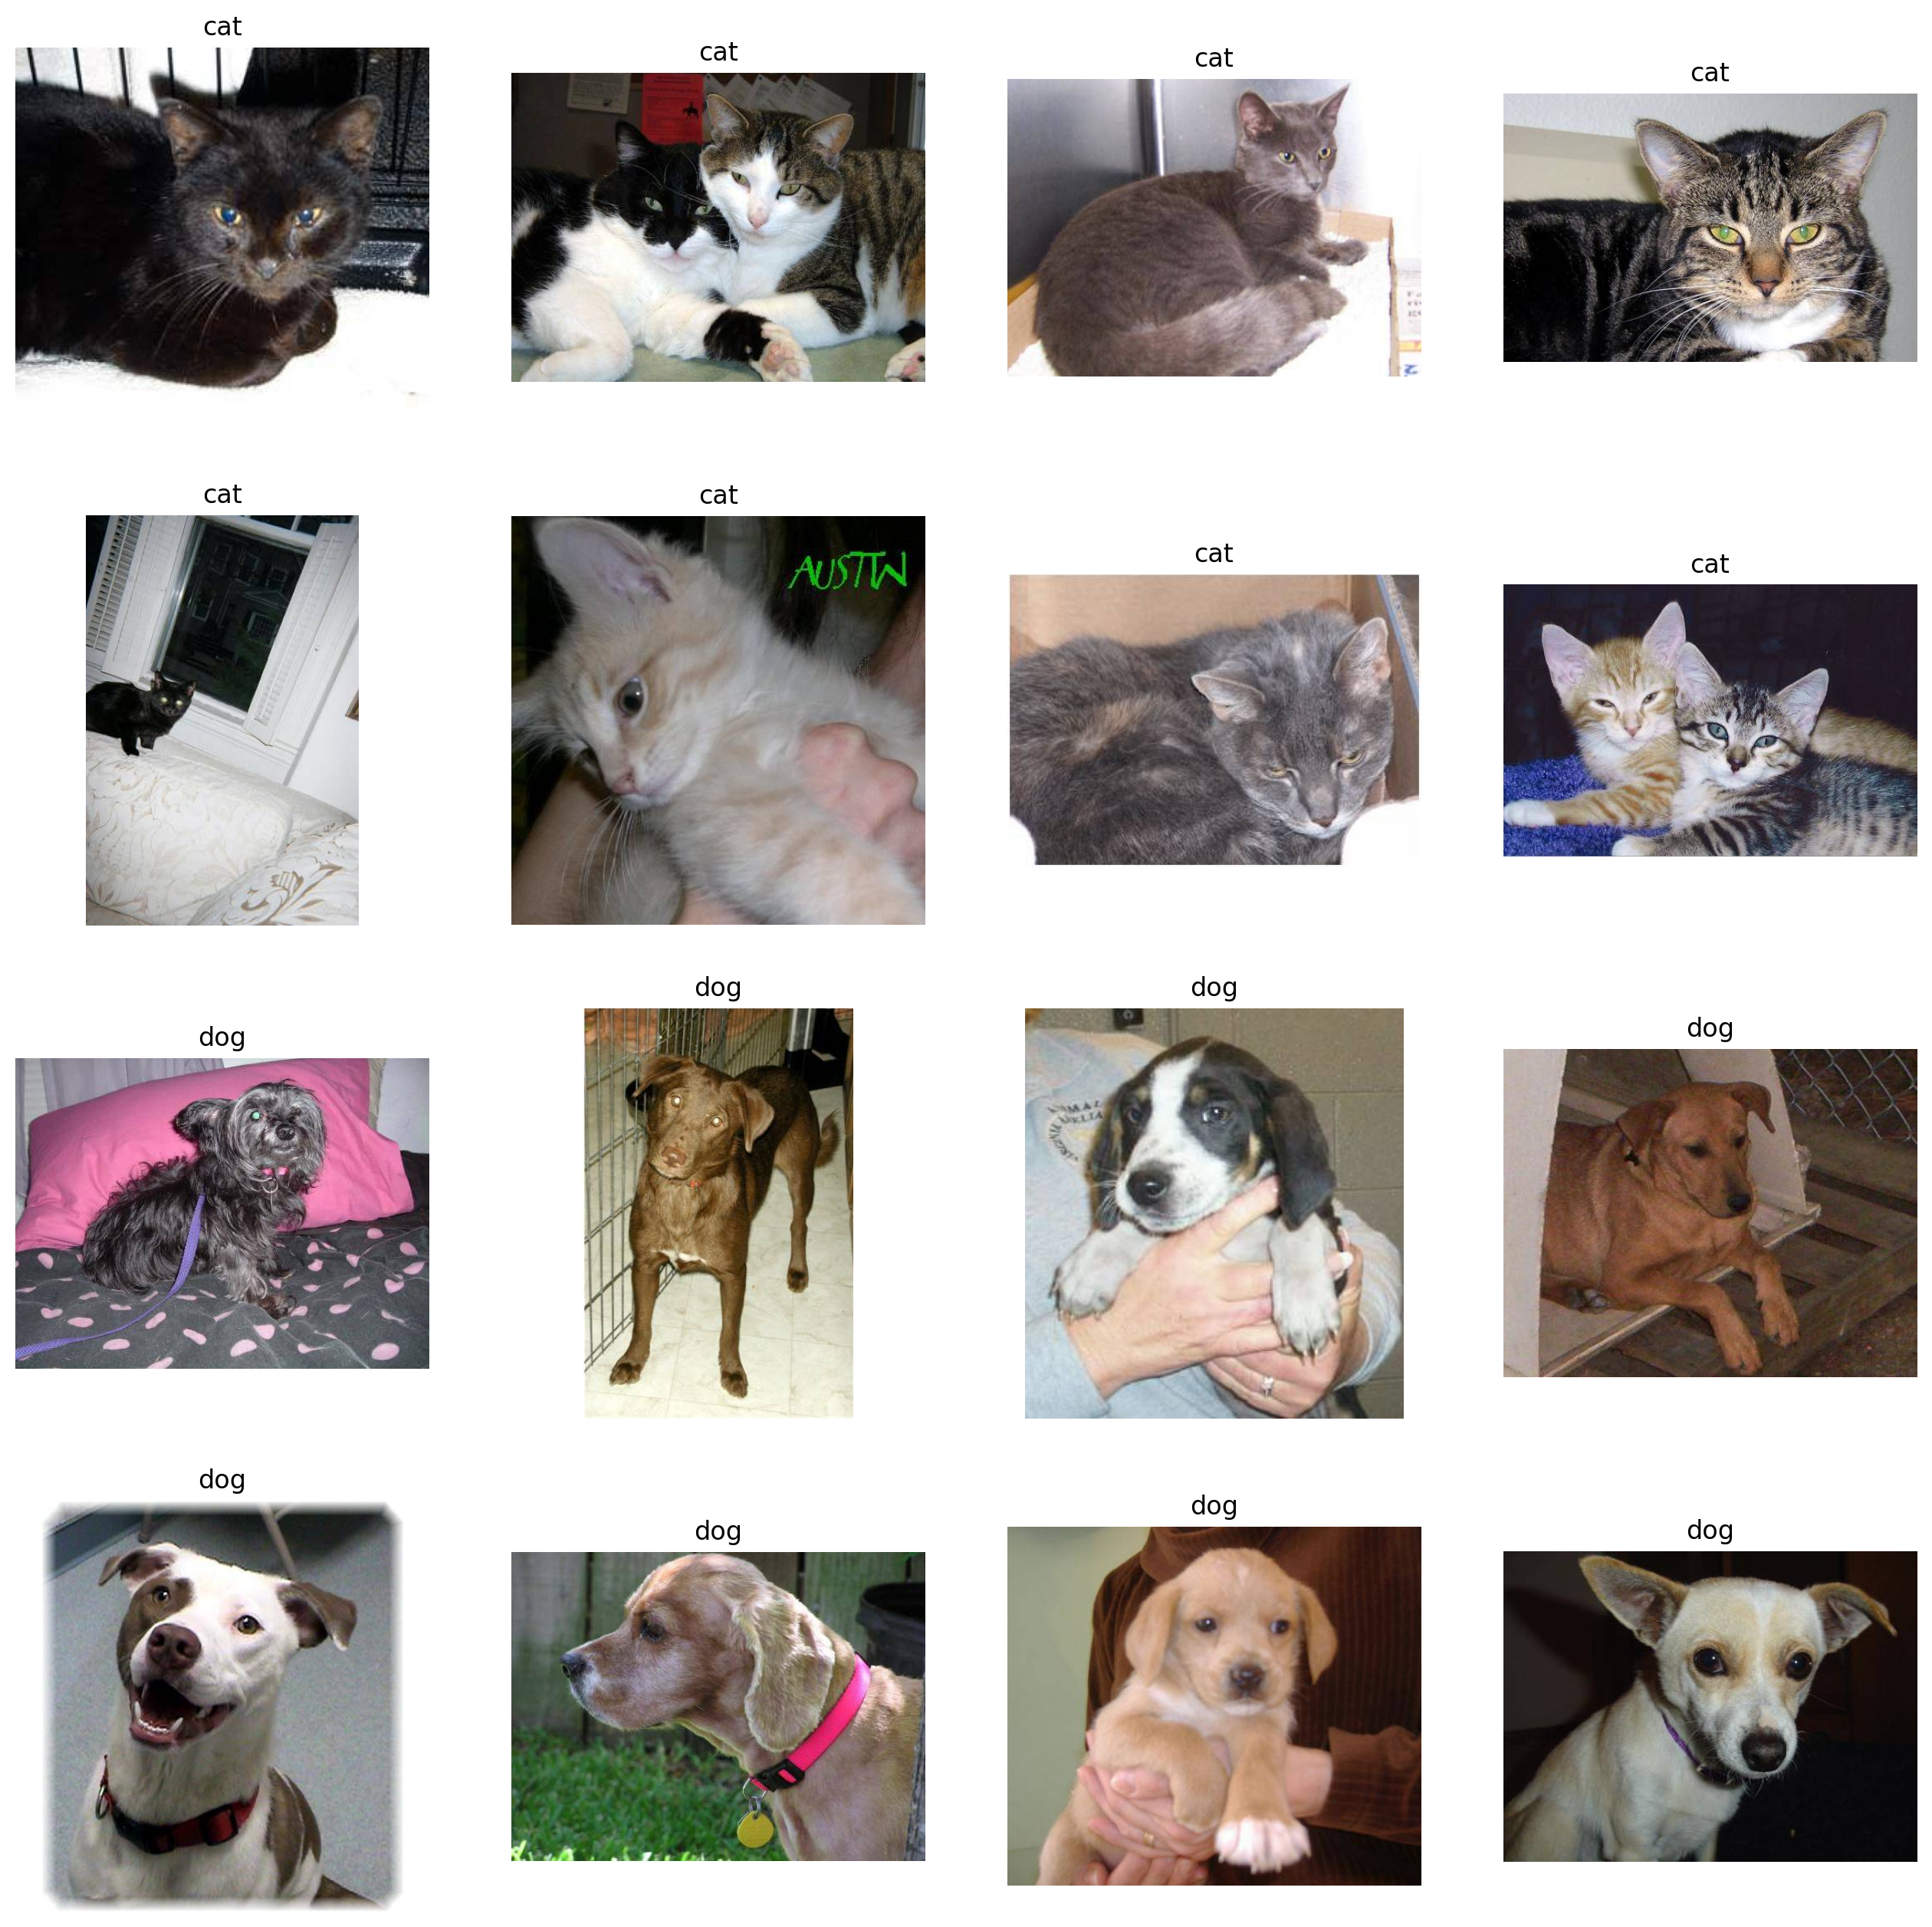

In [12]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(img_path.split(os.sep)[4][:3])

plt.show()

## Step 3 : training a model

In [14]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
# can use image_dataset_from_directory to fit the memory
X_train = train_generator[0][0]

In [16]:
print(X_train[0].shape)

(150, 150, 3)


### Question

Create a CNN model able to be trained on 150x150x3 images. Show its summary with the `model.summary()`method.

In [17]:
# YOUR CODE HERE

# https://www.tensorflow.org/tutorials/load_data/images

num_classes = 2

model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dense(num_classes)
])

2022-12-01 19:55:49.350287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Question

Compile and train your model to reach a validation accuracy > 70%.

In [18]:
# Compile and train the model


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.build((None, 16))

# change the model -> use conv2D, maxpool, add data augmentation, change train test split, plot the 
# cross entroppy


history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
    batch_size=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)


" data augmentation, batch norm"

Epoch 1/10
100/100 [==============================] - 13s 120ms/step - loss: 0.6791 - accuracy: 0.5775 - val_loss: 0.6295 - val_accuracy: 0.6200
Epoch 2/10
100/100 [==============================] - 12s 119ms/step - loss: 0.6081 - accuracy: 0.6680 - val_loss: 0.6098 - val_accuracy: 0.6620
Epoch 3/10
100/100 [==============================] - 11s 112ms/step - loss: 0.5668 - accuracy: 0.7105 - val_loss: 0.5651 - val_accuracy: 0.7050
Epoch 4/10
100/100 [==============================] - 12s 120ms/step - loss: 0.5096 - accuracy: 0.7505 - val_loss: 0.6739 - val_accuracy: 0.6260
Epoch 5/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4186 - accuracy: 0.8135 - val_loss: 0.6078 - val_accuracy: 0.7040
Epoch 6/10
100/100 [==============================] - 11s 111ms/step - loss: 0.3411 - accuracy: 0.8560 - val_loss: 0.6584 - val_accuracy: 0.7010
Epoch 7/10
100/100 [==============================] - 11s 111ms/step - loss: 0.3012 - accuracy: 0.8695 - val_loss: 0.6520 - val_ac

' data augmentation, batch norm'

2


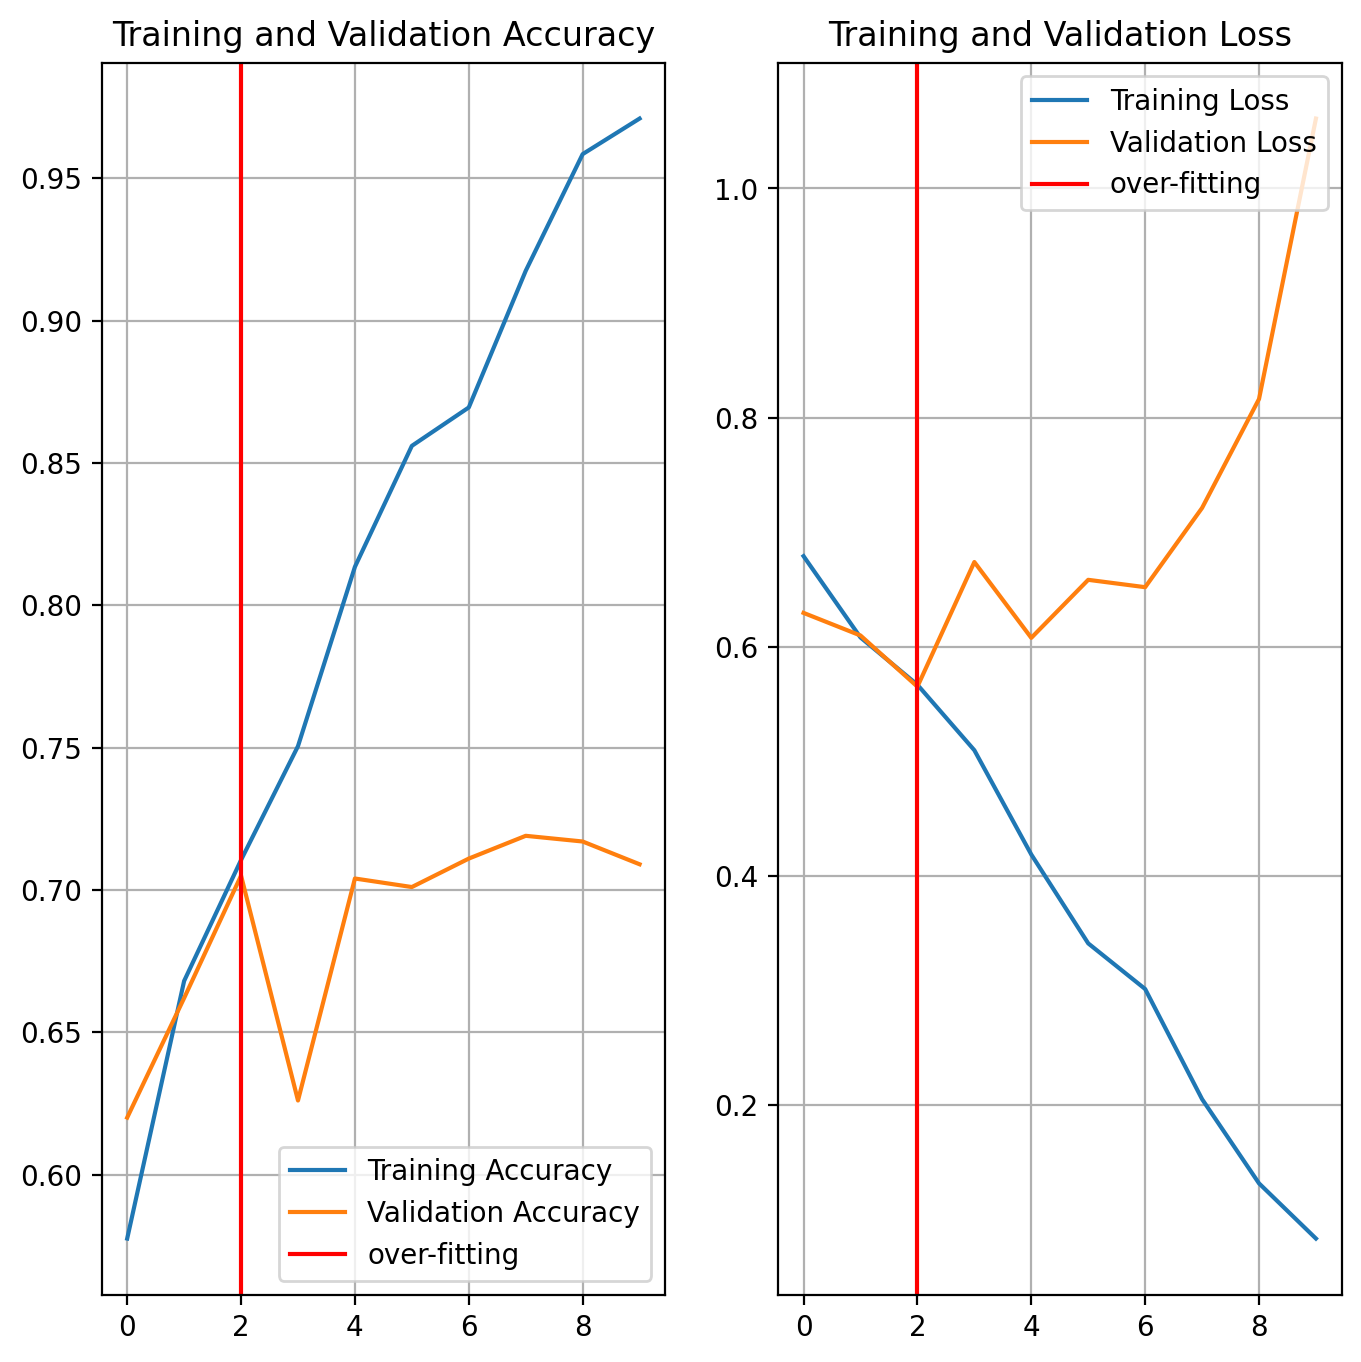

In [19]:
# Show training history
# code from https://www.tensorflow.org/tutorials/images/classification

import numpy as np 

#plot_loss_acc(history)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 10
epochs_range = range(epochs)

minimal_loss =  np.argmin(val_loss)# to see overfitting
print(minimal_loss)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x = minimal_loss, color = 'r', label = 'over-fitting')
plt.legend(loc='lower right')
plt.grid()

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x = minimal_loss, color = 'r', label = 'over-fitting')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()



In [27]:
# Retrieve final validation accuracy
val_acc = history.history['val_accuracy'][-1]

# Assert final accuracy
assert val_acc > 0.68

## Step 4: Preventing overfitting

### Adding data augmentation

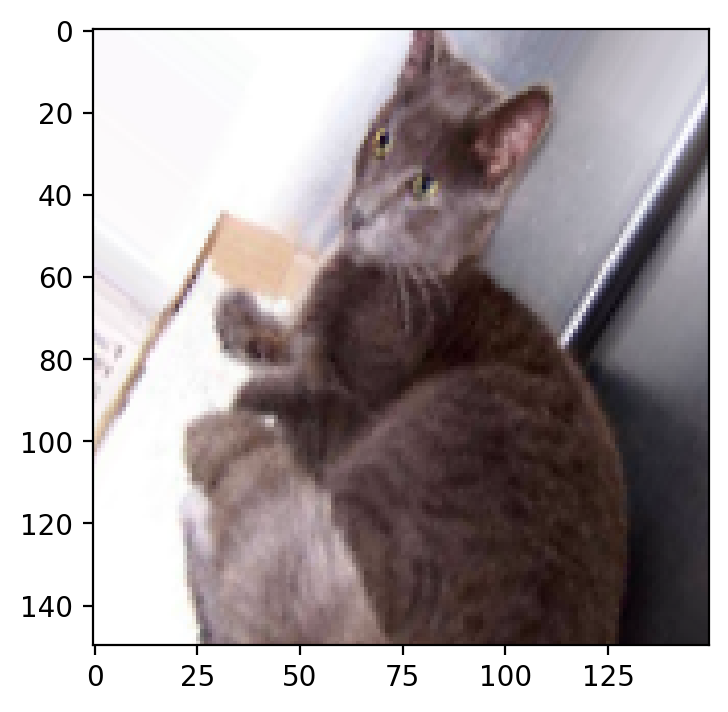

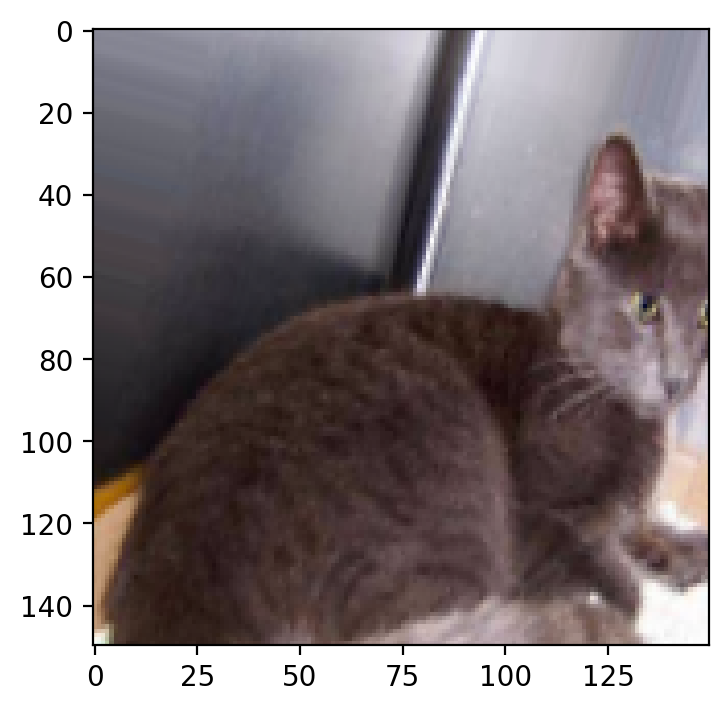

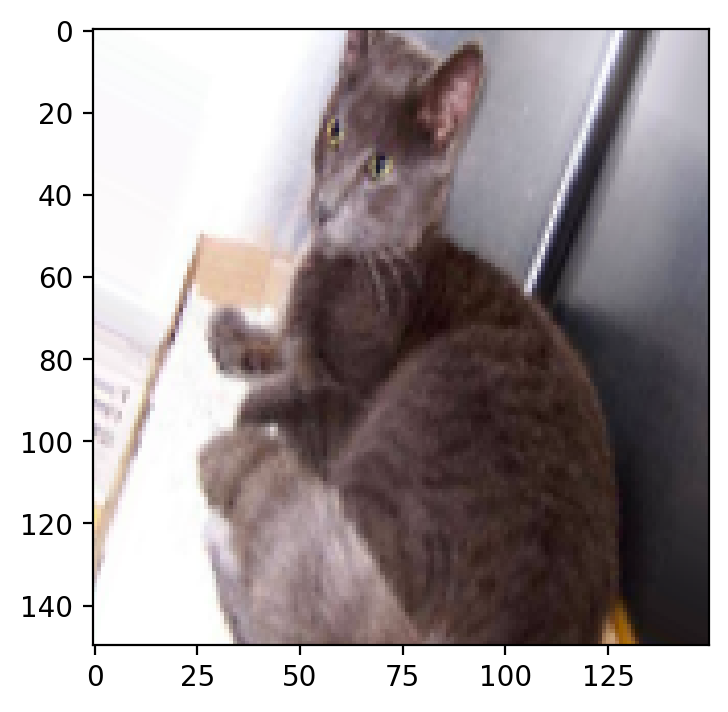

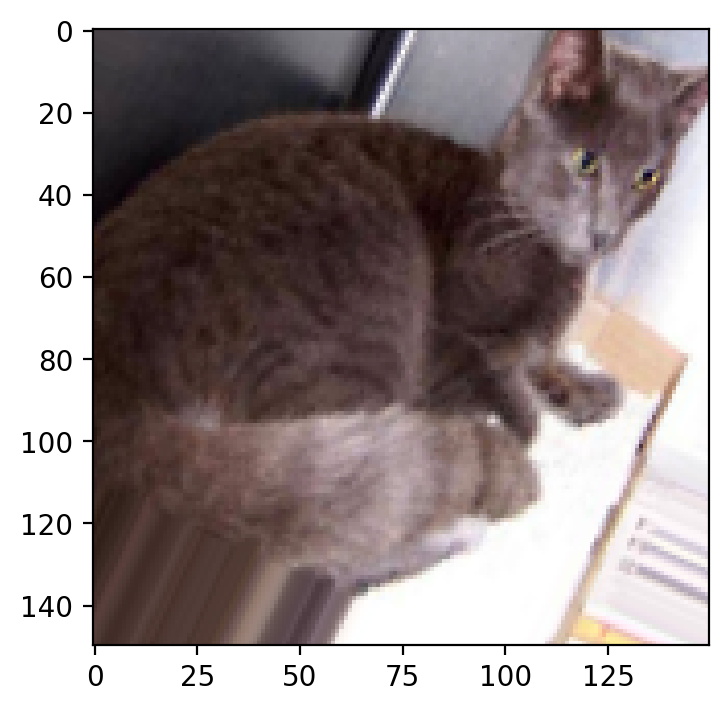

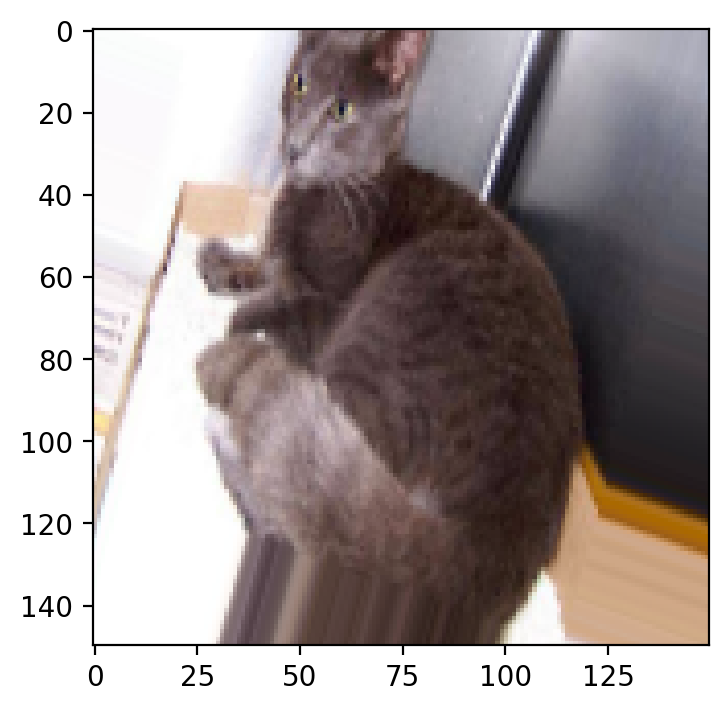

In [28]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i, figsize=(4, 4))
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

In [29]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Adding Dropout

### Question

Create a new model with a `Dropout` layer to your model just before the output layer.

In [30]:
# YOUR CODE HERE


num_classes = 2


model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])


### Question

Compile and train your model to reach a validation accuracy > 73%.

In [31]:
# Compile and train the model
model.compile('adam',
              'binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=30,
      batch_size=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/30
100/100 [==============================] - 15s 143ms/step - loss: 0.6942 - accuracy: 0.5035 - val_loss: 0.6882 - val_accuracy: 0.5640
Epoch 2/30
100/100 [==============================] - 14s 138ms/step - loss: 0.6930 - accuracy: 0.5370 - val_loss: 0.6898 - val_accuracy: 0.5050
Epoch 3/30
100/100 [==============================] - 14s 140ms/step - loss: 0.6896 - accuracy: 0.5355 - val_loss: 0.6743 - val_accuracy: 0.5620
Epoch 4/30
100/100 [==============================] - 14s 137ms/step - loss: 0.6855 - accuracy: 0.5525 - val_loss: 0.6834 - val_accuracy: 0.5310
Epoch 5/30
100/100 [==============================] - 14s 141ms/step - loss: 0.6811 - accuracy: 0.5610 - val_loss: 0.6624 - val_accuracy: 0.5990
Epoch 6/30
100/100 [==============================] - 14s 139ms/step - loss: 0.6751 - accuracy: 0.5945 - val_loss: 0.6530 - val_accuracy: 0.6190
Epoch 7/30
100/100 [==============================] - 14s 138ms/step - loss: 0.6453 - accuracy: 0.6300 - val_loss: 0.6360 - val_ac

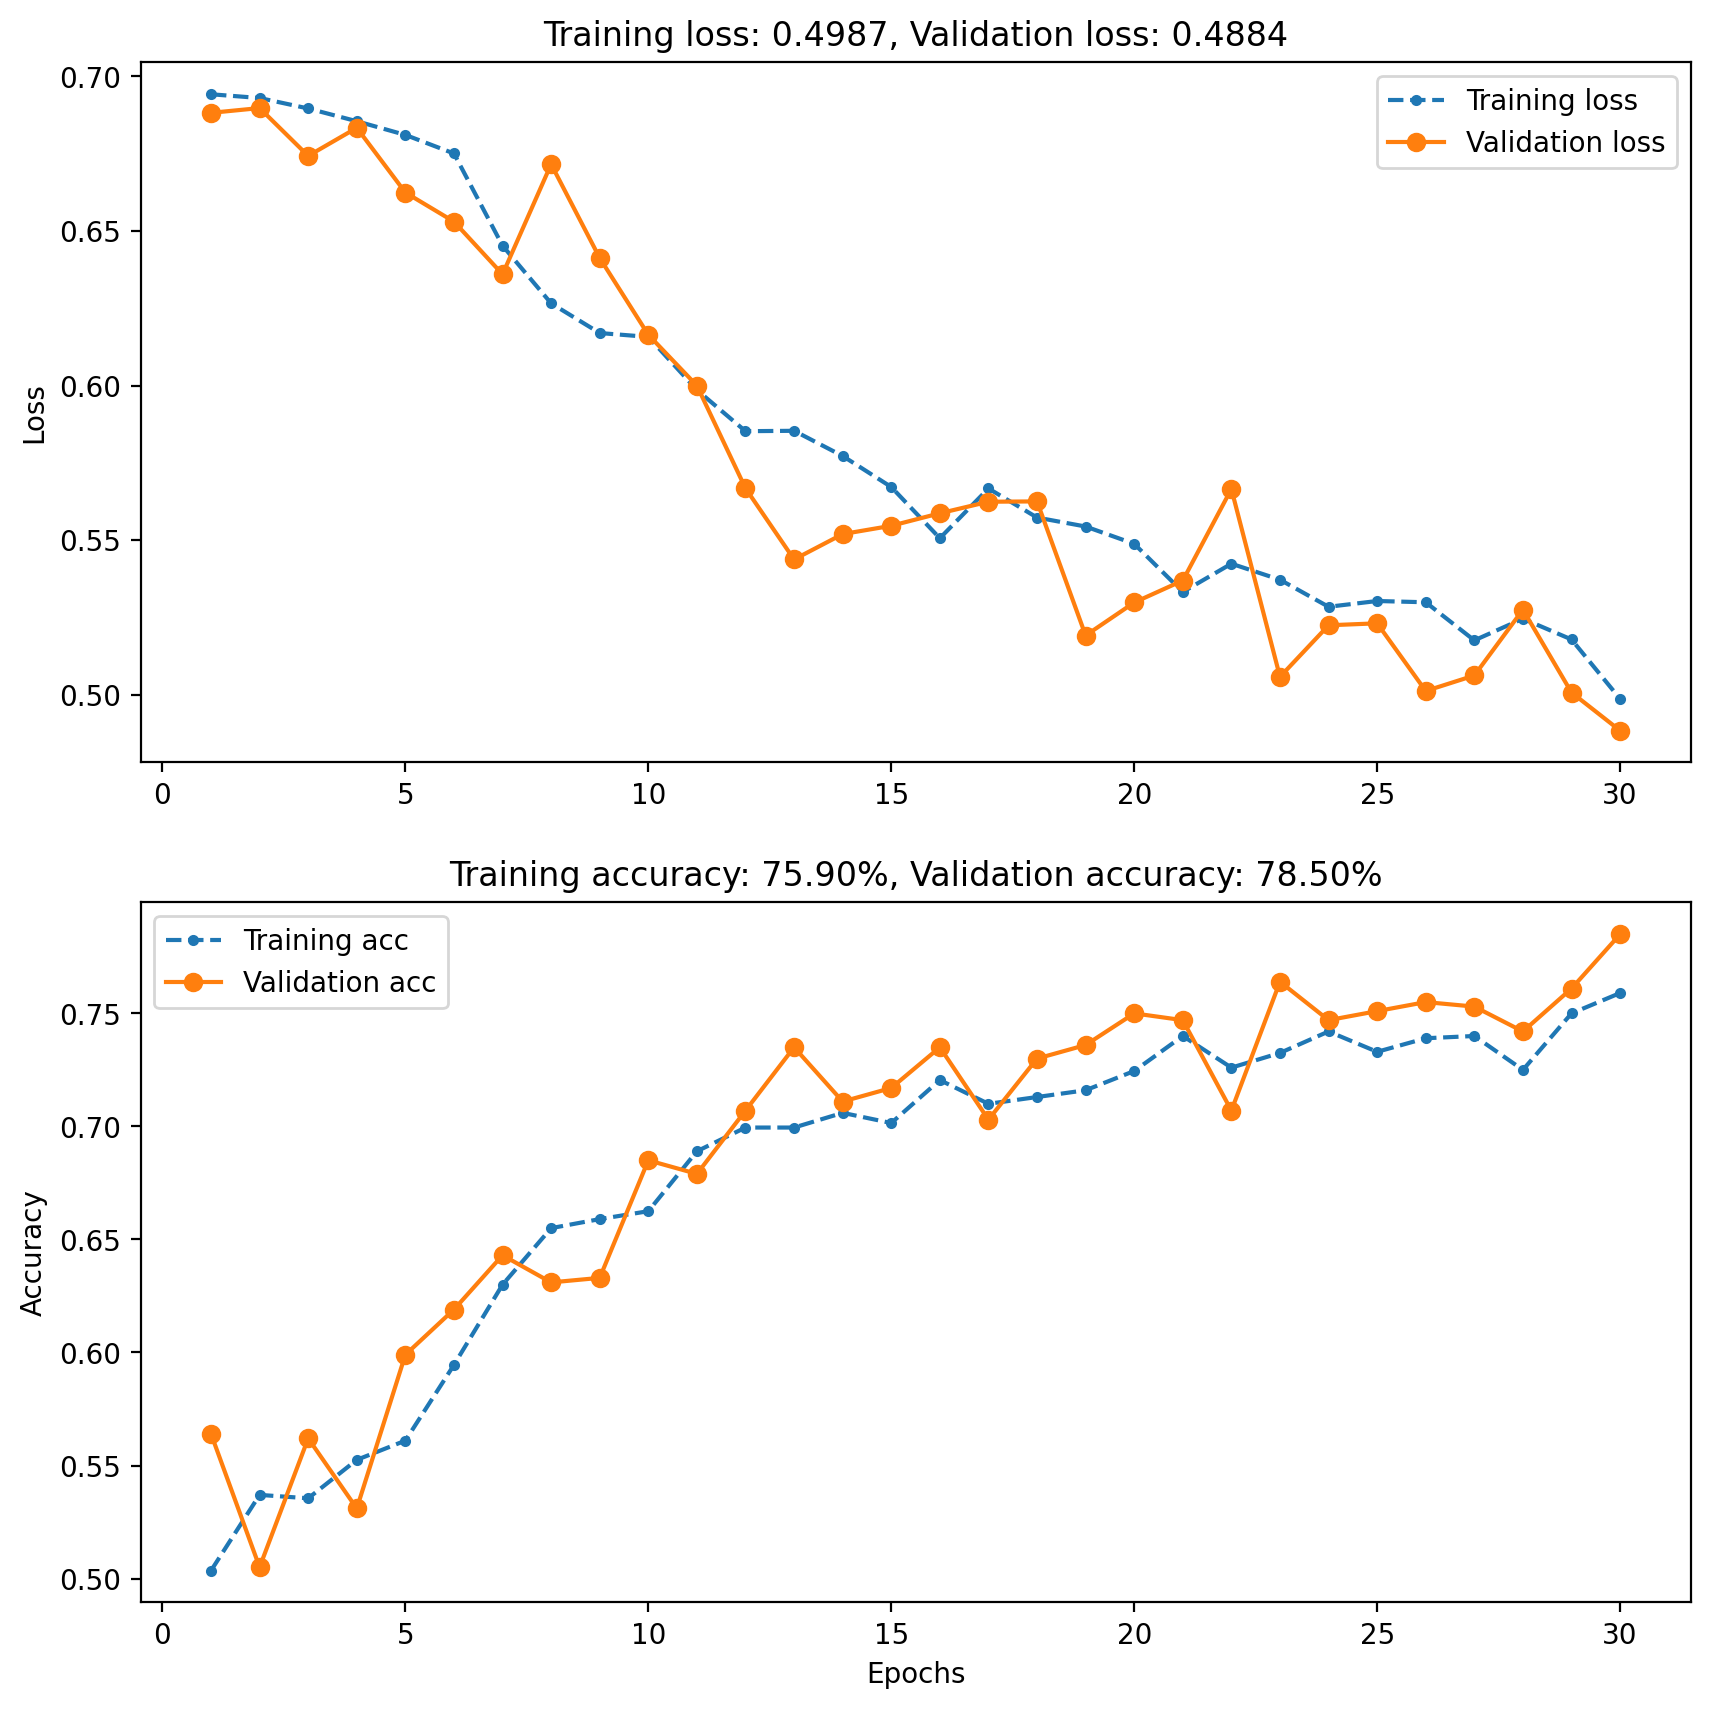

In [32]:
# Show training history
plot_loss_acc(history)

In [33]:
# Retrieve final validation accuracy
val_acc = history.history['val_accuracy'][-1]

# Assert final accuracy
assert val_acc > 0.73

## Step 5: Using a pretrained model

### Question

Implement feature extraction, using the convolution base of VGG16 in the `conv_base`variable.

In [20]:
# YOUR CODE HERE
conv_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)


conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Question

Add a Dense classifier on top of the convolutional base.

In [25]:
# YOUR CODE HERE

conv_base.trainable = False

inputs = tf.keras.Input(shape=(150, 150, 3))

x = tf.keras.layers.Rescaling(1./255)(inputs)

x = conv_base(inputs, training=False )

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)


### Question

Compile and train your model to reach a validation accuracy > 87%.

In [26]:
# Compile and train the model

model.compile('adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/15
100/100 [==============================] - 66s 653ms/step - loss: 1.2130 - accuracy: 0.8175 - val_lo

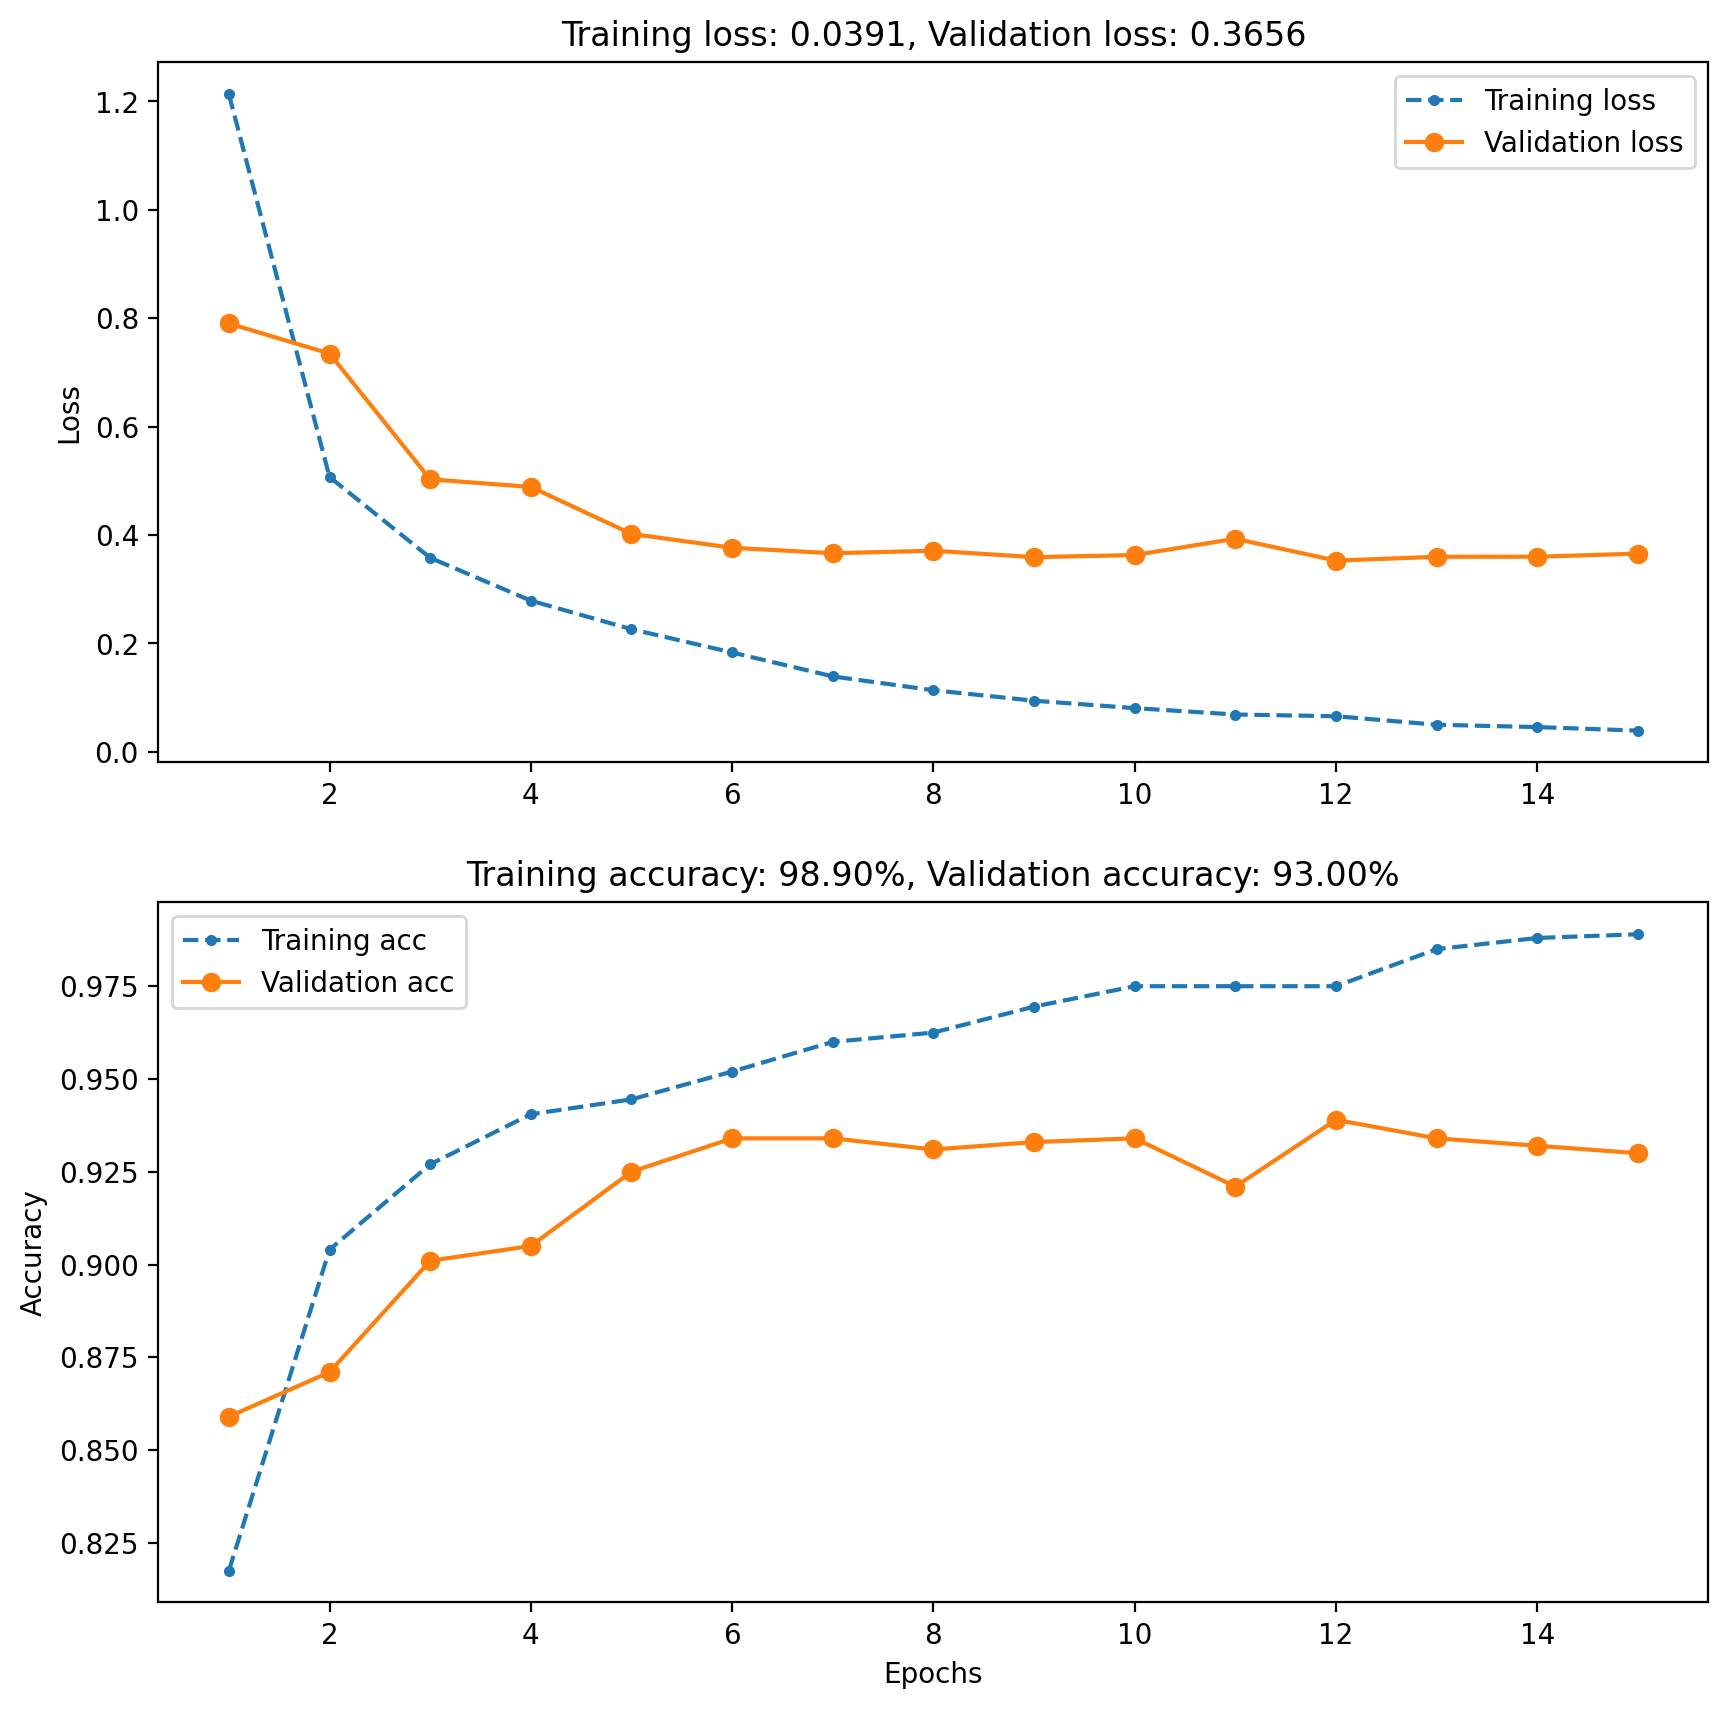

In [27]:
# Show training history
plot_loss_acc(history)

In [28]:
# Retrieve final validation accuracy
val_acc = history.history['val_accuracy'][-1]

# Assert final accuracy
assert val_acc > 0.87